In [3]:
import polars as pl
import matplotlib.pyplot as plt
import blitzbeaver as bb
from blitzbeaver.tracking_graph import MaterializedTrackerFrame, MaterializedTrackingChain

In [4]:
csv_path = "../../aptihramy/data/csv_cleaned"

start_year = 1835
end_year = 1850

dataframes = [
    pl.read_csv(f"{csv_path}/{year}.csv", infer_schema_length=10000)
    for year in range(start_year, end_year + 1)
]

In [5]:
for i in range(len(dataframes)):
    df = dataframes[i]
    dataframes[i] = df.with_columns(df["enfants_chez_parents_prenom"].str.split("|")
                                    .list.eval(pl.element().filter(pl.element() != ""))
                                    .alias("enfants_chez_parents_prenom"))

In [6]:
# load the graph from a .beaver file
path_graph = "../graph.beaver"

graph = bb.read_beaver(path_graph)

InvalidBeaverFileException: failed to deserialize beaver file

In [7]:
record_schema = bb.RecordSchema(
    [
        bb.FieldSchema("nom_rue", bb.ElementType.String),
        bb.FieldSchema("chef_prenom", bb.ElementType.String),
        bb.FieldSchema("chef_nom", bb.ElementType.String),
        bb.FieldSchema("chef_origine", bb.ElementType.String),
        bb.FieldSchema("epouse_nom", bb.ElementType.String),
        bb.FieldSchema("chef_vocation", bb.ElementType.String),
        bb.FieldSchema("enfants_chez_parents_prenom", bb.ElementType.MultiStrings),
    ]
)

In [ ]:
distance_metric_config = bb.DistanceMetricConfig(
    metric="lv_opti",
    caching_threshold=4,
    use_sigmoid=False,
    lv_substring_weight=0.5,
)
normal_memory_config = bb.MemoryConfig(
    memory_strategy="median",
)
multi_memory_config = bb.MemoryConfig(
    memory_strategy="mw-median",
    multiword_threshold_match=0.6,
    multiword_distance_metric=distance_metric_config,
)

config = bb.config(
    record_schema=record_schema,
    distance_metric_config=distance_metric_config,
    record_scorer_config=bb.RecordScorerConfig(
        record_scorer="average",
        weights=None,
        min_weight_ratio=None
    ),
    resolver_config=bb.ResolverConfig(
        resolving_strategy="best-match",
    ),
    memory_config=normal_memory_config,
    multistring_memory_config=multi_memory_config,
    interest_threshold=0.6,
    limit_no_match_streak=3,
    num_threads=10,
)

In [9]:
# compute the graph
graph = bb.execute_tracking(config, record_schema, dataframes, "debug")

[DEBUG]: processing frame 1...
[DEBUG]: [worker 9] process frame 1:  trackers: 438  cache size: 293313
[DEBUG]: [worker 7] process frame 1:  trackers: 438  cache size: 279768
[DEBUG]: [worker 6] process frame 1:  trackers: 438  cache size: 266623
[DEBUG]: [worker 5] process frame 1:  trackers: 438  cache size: 261237
[DEBUG]: [worker 4] process frame 1:  trackers: 438  cache size: 273535
[DEBUG]: [worker 3] process frame 1:  trackers: 438  cache size: 295912
[DEBUG]: [worker 2] process frame 1:  trackers: 441  cache size: 292580
[DEBUG]: [worker 8] process frame 1:  trackers: 438  cache size: 299527
[DEBUG]: [worker 10] process frame 1:  trackers: 438  cache size: 296776
[DEBUG]: frame: 1 dead trackers: 0
[DEBUG]: processing frame 2...
[DEBUG]: [worker 5] process frame 2:  trackers: 558  cache size: 351614
[DEBUG]: [worker 2] process frame 2:  trackers: 561  cache size: 378365
[DEBUG]: [worker 4] process frame 2:  trackers: 558  cache size: 354950
[DEBUG]: [worker 9] process frame 2:  

[3945, 1084, 1227, 955, 993, 1163, 1088, 1099, 1000, 1249, 1065, 1290, 1434, 914, 1032, 1159]
[0, 0, 0, 0, 695, 924, 1015, 963, 1089, 1021, 1068, 1065, 1001, 1072, 1092, 9692]
[0, 10876, 3125, 1434, 978, 668, 583, 450, 362, 343, 280, 272, 249, 273, 280, 296, 228]
[0, 10876, 3125, 1434, 978, 668, 583, 450, 362, 343, 280, 272, 249, 273, 280, 296, 228]
Number of chains: 20697
Percentage of matching records: 72.86%
Percentage of matching trackers: 84.27%
Percentage of divergences: 22.63%
Percentage of conflicts: 34.83%


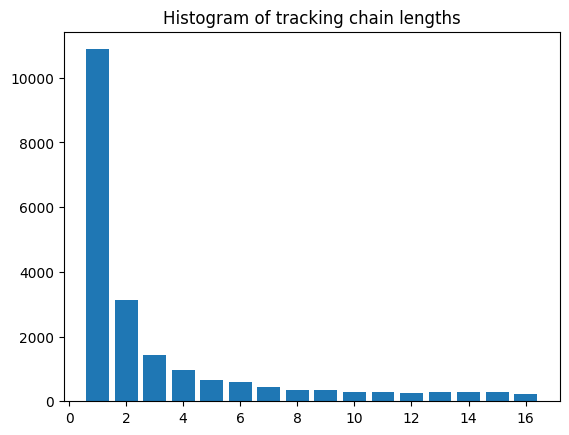

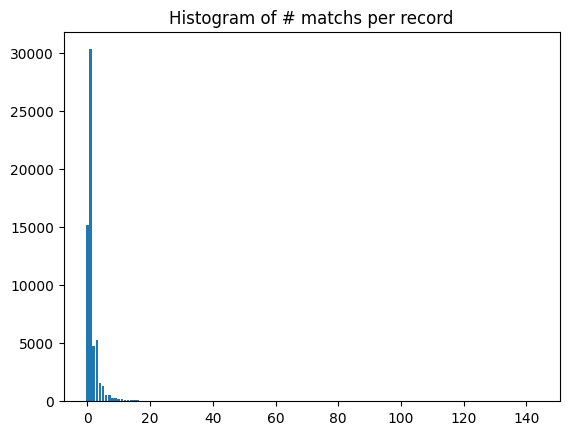

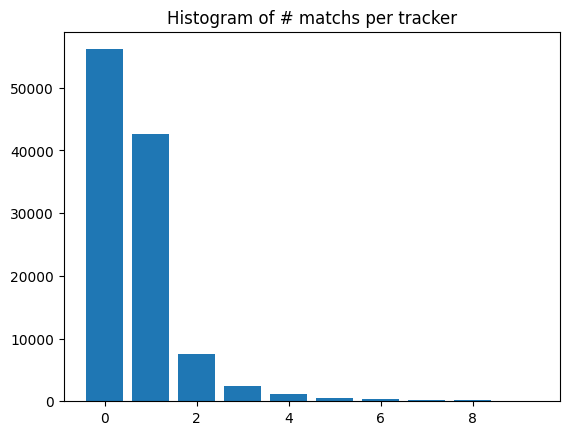

In [10]:
def aggregate_histograms(histograms: list[list[int]]) -> list[int]:
    """
    Aggregates a list of histograms into a single histogram.
    """
    max_len = max([len(h) for h in histograms])
    result = [0] * max_len
    for h in histograms:
        for i, v in enumerate(h):
            result[i] += v
    return result

def summary_graph(graph: bb.TrackingGraph):

    # compute the sum of the histograms for all frames
    histogram_records = aggregate_histograms([resolving.histogram_record_matchs for resolving in graph.diagnostics.resolvings])
    # do not show beyond 10 elements as the counts are very low
    histogram_records = histogram_records
    histogram_trackers = aggregate_histograms([resolving.histogram_tracker_matchs for resolving in graph.diagnostics.resolvings])
    histogram_trackers = histogram_trackers[:10]

    chain_metrics = bb.evaluate_tracking_chain_length(graph._raw)
    graph_metrics = bb.evaluate_tracking_graph_properties(graph._raw)
        
    records_match_ratios = graph_metrics.records_match_ratios[1:]
    trackers_match_ratios = graph_metrics.trackers_match_ratios[1:-1]
    avg_records_match = sum(records_match_ratios) / len(records_match_ratios)
    avg_trackers_match = sum(trackers_match_ratios) / len(trackers_match_ratios)

    per_divergence = sum(histogram_trackers[2:]) / sum(histogram_trackers[1:])
    per_conflict = sum(histogram_records[2:]) / sum(histogram_records[1:])

    a = [graph.diagnostics.get_tracker(id) for id in graph.trackers_ids]
    b = [graph.materialize_tracking_chain(id, dataframes, record_schema , None) for id in graph.trackers_ids]

    start_idx = [0] *16
    end_idx = [0]*16
    length = [0] *17
    
    for m in b:
        if len(m.frames) == 0:
            continue
        
        start = m.frames[0].frame_idx
        end = m.frames[-1].frame_idx
        
        start_idx[start] +=1
        end_idx[end] +=1
    
        length[len(m.matched_frames)] +=1
      
    print(start_idx)
    print(end_idx)
    print(length)
    print(chain_metrics.histogram)
    
    # start_idx = [0] *16
    # end_idx = [0]*16
    # length = [0] *16
    # for m in a:
    #     if m is None:
    #         continue
    #     if len(m.frames) == 0:
    #         continue
        
    #     start = m.frames[0].frame_idx
    #     end = m.frames[-1].frame_idx
        
    #     start_idx[start] +=1
    #     end_idx[end] +=1
    #     length[len(m.frames)-1] +=1
    
    # print(start_idx)
    # print(end_idx)
    # print(length)

    # total number of trackers created
    print(f"Number of chains: {len(graph.trackers_ids)}")
    # average percentage of records that have been match with an existing tracker
    print(f"Percentage of matching records: {avg_records_match*100:.2f}%")
    # average percentage of trackers that have match with a record of the current frame
    print(f"Percentage of matching trackers: {avg_trackers_match*100:.2f}%")
    # number of times a tracker matched with more that one record
    # divided by the number of times a tracker matched with a record
    print(f"Percentage of divergences: {per_divergence*100:.2f}%")
    # number of times a record matched with multiple trackers
    # divided by the number of times a record matched with a tracker
    print(f"Percentage of conflicts: {per_conflict*100:.2f}%")

    plt.bar(range(1, len(chain_metrics.histogram)), chain_metrics.histogram[1:])
    plt.title("Histogram of tracking chain lengths")
    plt.show()

    plt.bar(range(len(histogram_records)), histogram_records)
    plt.title("Histogram of # matchs per record")
    plt.show()

    plt.bar(range(len(histogram_trackers)), histogram_trackers)
    plt.title("Histogram of # matchs per tracker")
    plt.show()
    
summary_graph(graph)

Number of chains: 20670
Percentage of matching records: 72.91%
Percentage of matching trackers: 84.32%
Percentage of divergences: 22.67%
Percentage of conflicts: 34.77%


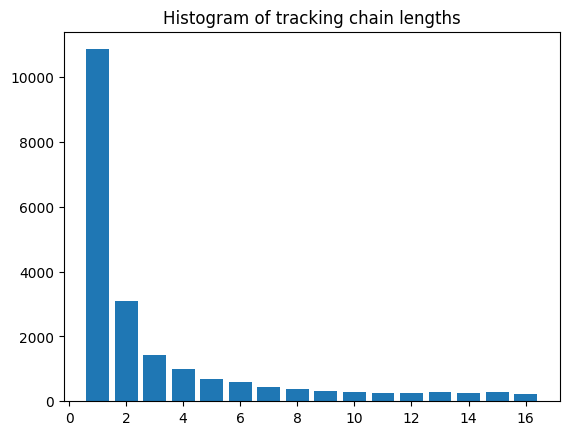

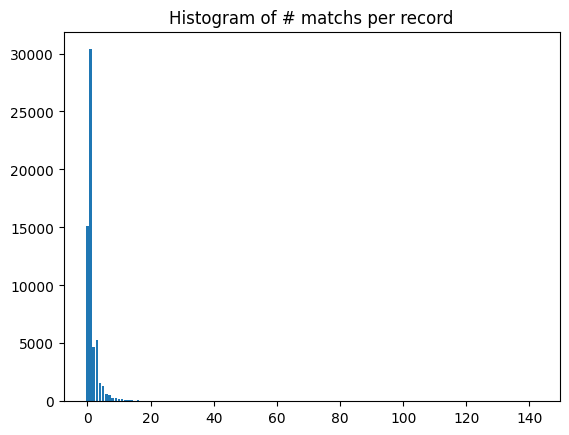

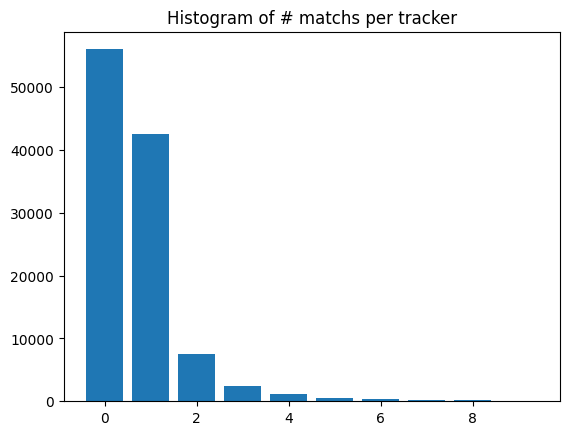

In [ ]:
summary_graph(graph)

In [1]:
path_graph = "../graph.beaver"

bb.save_beaver(path_graph, graph)

NameError: name 'bb' is not defined

In [2]:
normalization_config = bb.NormalizationConfig(
    threshold_cluster_match=0.5,
    min_cluster_size=2,
    distance_metric=distance_metric_config,
)

NameError: name 'bb' is not defined

In [ ]:
normalized_dfs = bb.execute_normalization(
    normalization_config,
    record_schema,
    graph,
    dataframes,
)

In [ ]:
def find_chain_with_length(graph: bb.TrackingGraph, start_idx: int, length: int) -> None:
    idx = start_idx
    while idx < len(graph.trackers_ids):
        tracker_id = graph.trackers_ids[idx]
        chain = graph._raw.get_tracking_chain(tracker_id)
        if len(chain) >= length:
            return tracker_id
        idx += 1
    return None

In [ ]:
# chain = find_chain_with_length(graph, dataframes, record_schema, 0, 3)
tracker_id = find_chain_with_length(graph, 2000, 15)
chain = graph.materialize_tracking_chain(tracker_id, dataframes, record_schema, normalized_dataframes=normalized_dfs)
chain.as_dataframe()

In [ ]:
chain.as_dataframe(normalized=True)

In [ ]:
df = chain.as_dataframe()

In [ ]:
def get_col_as_list(df: pl.DataFrame, col: str) -> list[str]:
    return [v for v in df[col] if v is not None]

In [ ]:
words = [
    "magimelien",
    "mazimilien",
    "mazirelien",
    "marinelien",
    "hgdfzs",
    "bob",
    "boob",
]
bb.compute_median_word(words)


In [ ]:
bb.compute_words_clusters(
    words,
    distance_metric_config,
    threshold_match=0.6,
)

In [ ]:
get_col_as_list(df, "nom_rue")

In [ ]:
bb.normalize_words(
    get_col_as_list(df, "nom_rue"),
    distance_metric_config,
    threshold_match=0.6,
    min_cluster_size=2,
)